In [48]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation


In [49]:
becaons = np.array([[-2.5, -2.5], [2.5, -2.5], [-2.5, 2.5], [2.5, 2.5]])
x0 = np.array([0, 0])
sigma_transition = 0.05
sigma_measurement = 0.0001
step_size = 0.9


In [50]:
def get_range_meas(x, beacons):
    return np.linalg.norm(beacons - x, axis=1)

def get_range_meas_with_noise(x, beacons, sigma = sigma_measurement):
    return get_range_meas(x, beacons) + np.random.normal(0, sigma, beacons.shape[0])

In [51]:
def transition_model(x, command):
    return x + command

def transition_model_with_noise(x, command, sigma = sigma_transition):
    return transition_model(x, command) + np.random.normal(0, sigma, x.shape[0])

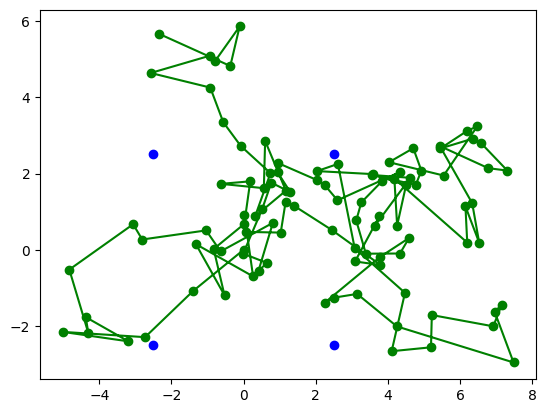

In [52]:
# genrate path and measurements
M = 100
path = [x0]
measurements = [get_range_meas_with_noise(x0, becaons)]
commands = np.random.normal(0, step_size, (M,2))
for i in range(M):
    path.append(transition_model(path[-1], command=commands[i]))
    measurements.append(get_range_meas_with_noise(path[-1], becaons))
    
#plt the path and measurements
path = np.array(path)
measurements = np.array(measurements)
plt.plot(path[:, 0], path[:, 1], 'g')
plt.scatter(becaons[:, 0], becaons[:, 1], c='b')
plt.scatter(path[:, 0], path[:, 1], c='g')
plt.show()


In [53]:
def propgate_all_particle(particle, command):
    return np.array([transition_model_with_noise(particle[i], command) for i in range(particle.shape[0])])

def calc_weight(particle, meas):
    return np.exp(-np.linalg.norm(get_range_meas(particle, becaons) - meas))

def calc_all_weight(particles, meas):
    return np.array([calc_weight(particles[i], meas) for i in range(particles.shape[0])])

def normalize_weight(weight):
    return weight / np.sum(weight)

def calc_N_eff(weight):
    return 1 / np.sum(weight ** 2)

def resampling(particles, weight):
    n_eff = calc_N_eff(weight)
    if n_eff < particles.shape[0]:
        return particles[np.random.choice(particles.shape[0], particles.shape[0], p=weight)]
    else:
        return particles

    
def run_particle_filter_step(particles, command, meas):
    weight = calc_all_weight(particles, meas)
    weight = normalize_weight(weight)
    particles = resampling(particles, weight)
    particles = propgate_all_particle(particles, command)
    return particles, weight

def run_particle_filter(m,commands,particles):
    for i in range(m):
        particles, weight = run_particle_filter_step(particles, commands[i-1], measurements[i])

MovieWriter imagemagick unavailable; using Pillow instead.


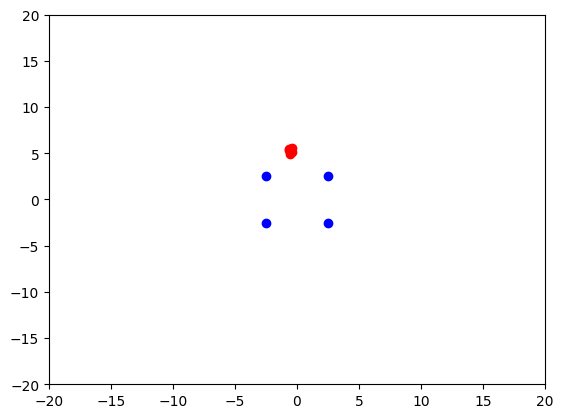

In [54]:
# sample unfomrly particles:
N = 10
particles = np.random.uniform(-10, 10, (N, 2))
#animation of particle filter and save as a gif:
fig, ax = plt.subplots()
sc_path, = ax.plot([], [], c='g',marker='o')
sc = ax.scatter([], [], color='red')
sc_beacons = ax.scatter(becaons[:, 0], becaons[:, 1], c='b')
def init():
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    sc_path.set_data([], [])
def animate(i):
    global particles
    sc_path.set_data(path[:i+1, 0],path[:i+1, 1])
    sc.set_offsets(particles)
    particles, weight = run_particle_filter_step(particles, commands[i], measurements[i])
    return sc, sc_path
ani = animation.FuncAnimation(fig, animate, frames=M, init_func=init, interval=500)
ani.save('particle_filter.gif', writer='imagemagick')


In [55]:
path[i]

array([-0.36950688,  4.82219252])